<center> <span style="color:indigo">Métodos Estadísticos Básicos</span> </center> 

<div style="text-align: center;">
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5e/Logo-cucea.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 1. Estadística Descriptiva: Limpieza y preparación de datos del dataset de Titanic </span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>


# Limpieza y preparación de datos en Machine Learning

Antes de entrenar cualquier modelo de machine learning, es fundamental realizar un proceso cuidadoso de **limpieza (data cleaning)** y **preparación (data wrangling) de los datos**. En el mundo real, los datos casi nunca vienen en un formato limpio o listo para usar: pueden tener errores, valores faltantes, formatos inconsistentes o información irrelevante. Si no se tratan adecuadamente, estos problemas pueden afectar seriamente el rendimiento y la interpretación de los modelos.

En este notebook nos enfocaremos a:
- Identificar y corregir problemas comunes en los datos.
- Transformar columnas para que puedan ser interpretadas por algoritmos de machine learning.
- Crear nuevas variables que representen mejor la información contenida en los datos originales.

Para ello, trabajaremos con un caso clásico y muy conocido: el dataset de los pasajeros del **Titanic**. El contexto de este dataset puede ser revisado en la la sección correspondiente de los los [datos](https://github.com/IvTole/MachineLearning_InferenciaBayesiana_CUGDL/tree/main/data/titanic). Normalmente, este dataset tiene como objetivo realizar una predicción sobre si el pasajero sobrevivió o no sobrevivió basado en sus características.

## Importacíon de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy.stats as st
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix


import os

### Carga y exploración inicial de los datos

In [2]:
data_path = "../data" # carpeta donde tenemos los datasets del curso
filename = "titanic/titanic.csv"
fullpath = os.path.join(data_path, filename)

df_titanic = pd.read_csv(fullpath)
df_titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# Dimensión de los datos
df_titanic.shape

(1309, 14)

Observamos que tenemos 1309 registros, con 14 variables. En la documentación de los datos podemos checar que las variables o características de los pasajeros son las siguientes:

| Variable | Descripción |
|----------|-------------|
| pclass | Clase del pasajero (1 = 1ra clase, 2 = 2da clase, 3 = 3ra clase) **Variable objetivo** |
| survived | Supervivencia (0 = No, 1 = Sí) |
| name | Nombre del pasajero |
| sex | Sexo del pasajero |
| age | Edad del pasajero en años |
| sibsp | Número de hermanos/cónyuges a bordo |
| parch | Número de padres/hijos a bordo |
| ticket | Número de boleto |
| fare | Tarifa del pasajero |
| cabin | Número de cabina |
| embarked | Puerto de embarque (C = Cherbourg, Q = Queenstown, S = Southampton) |
| boat | Bote salvavidas (si sobrevivió) |
| body | Número de identificación del cuerpo (si no sobrevivió y fue recuperado) |
| home.dest | Hogar/Destino |

In [4]:
# Información del dataset
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


Con la información del dataset nos podemos dar cuenta de varias cosas. Por un lado, tenemos el tipo de variables (marcado como **Dtype) de Pandas que se identifican automáticamente. Es común ver en datasets que variables numéricas, por ejemplo, podrían ser tomadas como strings al momento de cargarlas, o que una variable que debería ser de tipo `datetime` está marcada como un string. Recordemos que una parte importante de trabajar con Python son el tipo de objetos, cada uno con distintos métodos, así que es necesario checar que nuestras variables estén correctamente tipificadas.

Por otro lado, también observamos que algunas de nuestras variables no contienen todos los 1309 registros o filas. Estos registros **"vacíos"** de estas variables son llamados **valores nulos**, y también se tienen que tomar en cuenta.

## Limpieza de datos (Data Cleaning)

El primer paso en todo proceso de análisis de datos es asegurarnos de que los datos sean **confiables y consistentes**. Esto implica detectar y corregir errores, valores faltantes, duplicados o formatos incorrectos. Este proceso se conoce como **data cleaning**, y es fundamental para evitar que los modelos aprendan patrones erróneos o se vean sesgados por datos defectuosos.

En esta sección nos enfocaremos en:
- Identificar columnas con valores nulos o incompletos.
- Analizar el tipo de información que contienen para decidir si deben imputarse, eliminarse o transformarse.
- Validar que no haya registros duplicados o inconsistencias en los datos.

Una limpieza adecuada mejora la calidad del dataset y sienta las bases para un análisis más robusto.

In [5]:
# Revisión de valores nulos por columna
null_counts = df_titanic.isnull().sum()
null_percent = (null_counts / len(df_titanic)) * 100

# Tabla resumen de valores nulos
missing_data = pd.DataFrame({
    'Valores nulos': null_counts,
    '% del total': null_percent.round(2)
})

display(missing_data)

,Valores nulos,% del total
pclass,0,0.00
survived,0,0.00
name,0,0.00
sex,0,0.00
age,263,20.09
sibsp,0,0.00
parch,0,0.00
ticket,0,0.00
fare,1,0.08
cabin,1014,77.46


Al revisar la tabla anterior, podemos observar que algunas columnas contienen una cantidad significativa de valores faltantes. Por ejemplo, la variable `Cabin` tiene un alto porcentaje de valores nulos, lo cual sugiere que esta información no fue registrada para la mayoría de los pasajeros. En contraste, `Age` presenta una cantidad moderada de datos faltantes que podrían imputarse sin perder demasiada información, mientras que `Embarked` tiene pocos nulos, lo que facilita su tratamiento.

Este tipo de análisis es crucial para tomar decisiones informadas: podemos eliminar columnas con demasiada información faltante, imputar valores con estadísticas como la mediana o moda, o incluso crear una nueva categoría que represente la ausencia de datos si se considera relevante para el modelo. A continuación, tomaremos acciones concretas para limpiar el dataset.

### Tratamiento de valores nulos


In [6]:
# A veces es útil hacer una copia del dataframe, pues algunos métodos alteran el dataframe original
# Esto es especialmente problemático en notebooks de jupyter, pues podriamos ejecutar una misma celda varias veces
# De esta forma, al hacer varias ejecuciones, evitamos realizar varias veces la misma operacion por error

df_titanic_clean = df_titanic.copy()

# Eliminamos la columna "Cabin" por tener demasiados valores faltantes
df_titanic_clean.drop(columns="cabin", inplace=True)

# Eliminamos la variable "body" porque tiene una correlación 1 a 1 con la variable survived, i.e., si hay cuerpo quiere decir que no sobrevivió
df_titanic_clean.drop(columns="body", inplace=True)

# Los valores age tienen un 20% de datos faltantes
# Una de muchas formas de imputación de datos es rellenar los valores faltantes por un estadístico de la misma, por ejemplo, la mediana
df_titanic_clean.fillna({'age': df_titanic_clean['age'].median()}, inplace=True)

# En la columna 'Embarked' quizá podamos utilizar la moda para rellenar datos faltantes
df_titanic_clean.fillna({'embarked': df_titanic_clean['embarked'].mode()[0]}, inplace=True)

# La variable fare solo tiene un valor nulo, así que podríamos eliminar toda la fila completa que contenga este valor nulo, sin hace que esto altere nuestro análisis
df_titanic_clean = df_titanic_clean.dropna(subset=['fare'])

# Y volvemos a validar que ya no queden valores nulos
# Recuerda que siempre es útil hacer una pausa para checar que los pasos se encuentren bien aplicados

null_counts = df_titanic_clean.isnull().sum()
null_percent = (null_counts / len(df_titanic_clean)) * 100

missing_data = pd.DataFrame({
    'Valores nulos': null_counts,
    '% del total': null_percent.round(2)
})

print(missing_data)

           Valores nulos  % del total
pclass                 0         0.00
survived               0         0.00
name                   0         0.00
sex                    0         0.00
age                    0         0.00
sibsp                  0         0.00
parch                  0         0.00
ticket                 0         0.00
fare                   0         0.00
embarked               0         0.00
boat                 822        62.84
home.dest            563        43.04


Basándonos en el análisis anterior, tomamos las siguientes decisiones:

- **`cabin`**: Se eliminó porque más del 75% de sus valores están ausentes, lo que la hace poco útil en su forma actual. Si fuera importante, podríamos haberla transformado en una variable binaria (`TieneCabina`), pero por ahora preferimos descartarla.
- **`body`**: Se elminió porque básicamente nos dice si el pasajero sobrevivió o no (variable objetivo).
- **`age`**: Se imputó con la **mediana**, ya que es una variable numérica y la mediana es menos sensible a valores extremos que la media.
- **`embarked`**: Solo tiene dos valores nulos, por lo que decidimos rellenarlos con la **moda** (el puerto más frecuente de embarque), preservando así la información sin eliminar registros.

Podemos ver que todavía tenemos dos variables problemáticas: **boat** y **home.dest**. Vamos a revisar más a detalle estas variables.

In [7]:
# Valores únicos de home.dest
df_titanic_clean['home.dest'].unique()

array(['St Louis, MO', 'Montreal, PQ / Chesterville, ON', 'New York, NY',
       'Hudson, NY', 'Belfast, NI', 'Bayside, Queens, NY',
       'Montevideo, Uruguay', 'Paris, France', nan, 'Hessle, Yorks',
       'Montreal, PQ', 'Winnipeg, MN', 'San Francisco, CA',
       'Dowagiac, MI', 'Stockholm, Sweden / Washington, DC',
       'Trenton, NJ', 'Glen Ridge, NJ', 'Youngstown, OH',
       'Birkdale, England Cleveland, Ohio', 'London / Winnipeg, MB',
       'Cooperstown, NY', 'St Leonards-on-Sea, England Ohio',
       'Los Angeles, CA', 'Pomeroy, WA', 'Omaha, NE', 'Philadelphia, PA',
       'Denver, CO', 'Belmont, MA', 'Washington, DC',
       'Austria-Hungary / Germantown, Philadelphia, PA',
       'Germantown, Philadelphia, PA', 'Bryn Mawr, PA',
       'Ascot, Berkshire / Rochester, NY', 'Little Onn Hall, Staffs',
       'Amenia, ND', 'New York, NY / Ithaca, NY', 'London, England',
       'Liverpool, England / Belfast', 'Stoughton, MA', 'Victoria, BC',
       'Lakewood, NJ', 'Roachdale, I

La columna `home.dest` contiene información textual sobre el destino final del pasajero, es decir, a dónde se dirigía al momento de embarcar en el Titanic. Aunque puede parecer útil, esta variable presenta varios retos: tiene muchos valores faltantes, su formato es inconsistente (algunos registros tienen múltiples destinos o nombres combinados), y no está estructurada de forma que se pueda usar directamente en un modelo de machine learning sin un procesamiento adicional. Por estas razones, y dado que no aporta valor directo para nuestro análisis actual, decidimos eliminarla para mantener el dataset limpio y manejable.

In [8]:
# Eliminamos la variable home.dest
df_titanic_clean.drop(columns="home.dest", inplace=True)

La columna `boat` indica el número del bote salvavidas en el que fue rescatado un pasajero. Aunque en principio parece una variable interesante, es importante tener en cuenta que **solo se asigna a personas que sobrevivieron**, por lo que está altamente correlacionada con nuestra variable objetivo (`survived`), al igual que la variable `body`. Incluir esta variable como predictor en un modelo de machine learning podría generar una **fuga de información (data leakage)**, es decir, estaríamos dándole al modelo una pista directa sobre el resultado que queremos predecir. Por esta razón, es preferible eliminarla del dataset antes de construir cualquier modelo.

In [9]:
# Eliminamos la variable boat
df_titanic_clean.drop(columns="boat", inplace=True)

In [10]:
# Hacemos nuevamente un chequeo antes de continuar

null_counts = df_titanic_clean.isnull().sum()
null_percent = (null_counts / len(df_titanic_clean)) * 100

missing_data = pd.DataFrame({
    'Valores nulos': null_counts,
    '% del total': null_percent.round(2)
})

print(missing_data)
print('dimensiones: ', df_titanic_clean.shape)

          Valores nulos  % del total
pclass                0          0.0
survived              0          0.0
name                  0          0.0
sex                   0          0.0
age                   0          0.0
sibsp                 0          0.0
parch                 0          0.0
ticket                0          0.0
fare                  0          0.0
embarked              0          0.0
dimensiones:  (1308, 10)


Con esto, nuestro dataset ya no contiene valores nulos y está listo para las siguientes etapas de preparación.

## Preparación de datos (Data Wrangling)

Una vez que los datos están limpios, el siguiente paso es transformarlos para que sean útiles en el análisis y modelado. A este proceso se le conoce como **data wrangling**, e implica reorganizar, codificar o crear nuevas variables a partir de las existentes. El objetivo es que el dataset esté en un formato adecuado tanto para su análisis exploratorio como para su uso con algoritmos de machine learning.

En esta sección realizaremos tareas como:
- Codificar variables categóricas en formato numérico.
- Crear nuevas variables que combinen o transformen las originales.
- Estandarizar formatos para facilitar comparaciones y visualizaciones.

Estas transformaciones nos ayudarán a representar mejor la información y preparar el terreno para construir modelos más efectivos.

### Codificación de variables categóricas

Los algoritmos de machine learning trabajan mejor (o simplemente solo trabajan) con datos numéricos. Por eso, uno de los pasos esenciales en la preparación de datos es transformar las variables categóricas en representaciones numéricas. En este caso, vamos a codificar dos columnas clave:

- `sex`: actualmente es una variable de texto (`male`/`female`). La convertiremos en 0 y 1 para representar ambos géneros.
- `embarked`: representa el puerto desde el que embarcó el pasajero (`C`, `Q` o `S`). Usaremos **codificación one-hot**, que crea una columna binaria para cada categoría sin imponer un orden arbitrario.

Además de estas técnicas, existen otras formas de codificación que pueden usarse según el tipo de variable o el modelo a emplear:

- **Label encoding**: asigna un número entero a cada categoría (por ejemplo, `0`, `1`, `2`), pero puede inducir relaciones ordinales artificiales.
- **Ordinal encoding**: útil cuando las categorías tienen un orden natural (por ejemplo, `bajo`, `medio`, `alto`).
- **Target encoding**: reemplaza categorías con el valor promedio de la variable objetivo, aunque puede causar sobreajuste si no se usa correctamente.

Estas transformaciones permiten que los modelos interpreten correctamente las variables categóricas sin asumir relaciones que no existen entre sus valores.


In [11]:
# Codificamos 'Sex' como 0 (female) y 1 (male)
df_titanic_clean['sex'] = df_titanic_clean['sex'].map({'female': 0, 'male': 1})

# Codificación one-hot para 'Embarked' (puerto de embarque)
# Se excluye 'S' para evitar multicolinealidad si usamos modelos lineales
# Pandas tiene un metodo pd.get_dummies para crear variables dummy asociadas a las columnas categoricas
df_titanic_clean = pd.get_dummies(df_titanic_clean, columns=['embarked'], drop_first=True, dtype=int) ## drop_firts remueve la primer categoría que se encuentra

# Verificamos el resultado
print(df_titanic_clean[['sex', 'embarked_Q', 'embarked_S']].head(10))


   sex  embarked_Q  embarked_S
0    0           0           1
1    1           0           1
2    0           0           1
3    1           0           1
4    0           0           1
5    1           0           1
6    0           0           1
7    1           0           1
8    0           0           1
9    1           0           0


Con la codificación de las variables `sex` y `embarked`, hemos transformado información cualitativa en un formato numérico que los modelos de machine learning pueden interpretar. Este paso, aunque sencillo, es esencial para garantizar que los algoritmos no malinterpreten categorías como si fueran números ordenados ni se vean afectados por formatos de texto.

En el caso de `embarked`, utilizamos **codificación one-hot** para representar las categorías como columnas binarias. Sin embargo, eliminamos una de las categorías (`embarked_C`) para evitar lo que se conoce como **multicolinealidad**: una situación en la que una columna puede deducirse perfectamente a partir de las otras. Este problema es especialmente importante en modelos lineales, ya que puede afectar la estabilidad y la interpretación del modelo. Al eliminar una de las categorías, conservamos la información completa sin redundancia.

Con estas transformaciones, ahora podemos continuar creando, de ser posible, nuevas variables que capten patrones más complejos o relaciones más implícitas entre las características o atributos.

## Creación de nuevas variables (Feature Engineering)

Una vez que los datos están limpios y las variables categóricas han sido codificadas, podemos enriquecer el dataset creando **nuevas variables derivadas** a partir de las existentes. Este proceso, conocido como *feature engineering*, permite capturar relaciones o patrones que no son evidentes de forma directa en los datos originales, y puede mejorar considerablemente el rendimiento de los modelos de machine learning.

En esta sección construiremos algunas variables que han demostrado ser útiles en este problema particular, como:
- `FamilySize`: número total de familiares a bordo.
- `IsAlone`: variable binaria que indica si el pasajero viaja solo.
- `Title`: el título social del pasajero extraído del campo `Name`.

Estas variables no solo aportan información adicional, sino que también nos ayudan a representar mejor el contexto social y familiar de cada individuo, algo que podría influir en sus probabilidades de supervivencia.


In [12]:
# Creamos una nueva variable familysize
# Sumamos hermanos/esposos + padres/hijos + el propio pasajero
df_titanic_clean['familysize'] = df_titanic_clean['sibsp'] + df_titanic_clean['parch'] + 1

# Creamos la variable 'isalone': 1 si viaja solo, 0 en caso contrario
# el metodo numpy np.where tiene la siguiente estructura de argumentos (condicion, valor que regresa si es verdadero, valor que regresa si es falso)
df_titanic_clean['isalone'] = np.where(df_titanic_clean['familysize'] == 1, 1, 0)

# Hacemos un chequeo
display(df_titanic_clean[['name','sibsp', 'parch', 'familysize', 'isalone']].head(10))

,name,sibsp,parch,familysize,isalone
0,"Allen, Miss. Elisabeth Walton",0,0,1,1
1,"Allison, Master. Hudson Trevor",1,2,4,0
2,"Allison, Miss. Helen Loraine",1,2,4,0
3,"Allison, Mr. Hudson Joshua Creighton",1,2,4,0
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,2,4,0
5,"Anderson, Mr. Harry",0,0,1,1
6,"Andrews, Miss. Kornelia Theodosia",1,0,2,0
7,"Andrews, Mr. Thomas Jr",0,0,1,1
8,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",2,0,3,0
9,"Artagaveytia, Mr. Ramon",0,0,1,1


In [13]:
# variable title

# Extraemos el título del nombre usando expresión regular
df_titanic_clean['title'] = df_titanic_clean['name'].str.extract(r',\s*([^\.]+)\.')  # Toma lo que hay entre la coma y el punto

# Vemos los títulos más comunes
print(df_titanic_clean['title'].value_counts())

title
Mr              756
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
Lady              1
Capt              1
Mme               1
Sir               1
Jonkheer          1
Dona              1
Don               1
the Countess      1
Name: count, dtype: int64


La columna `name` contiene más que el nombre completo del pasajero: incluye también un **título social** como `Mr.`, `Mrs.`, `Miss.`, `Master.`, entre otros. Estos títulos pueden proporcionar información relevante sobre la edad, el género o incluso la clase social del pasajero, lo cual puede influir en su probabilidad de supervivencia.

Para extraer estos títulos, utilizamos una **expresión regular** que localiza el texto entre la coma y el punto del nombre completo:

```python
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.')
```

Esta expresión funciona de la siguiente manera:

* `,` busca la coma que precede al título (por ejemplo, `"Bround, Mr. Owen"`).
* `\s*` permite cero o más espacios después de la coma.
* `([^\.]+)` selecciona cualquier conjunto de caracteres que no sean un punto, es decir, el título (`Mr`, `Miss`, etc.)
* `\.` indica el punto final que delimita el fin del título

El resultado es una nueva columna con títulos limpios, que luego podremos agupar y codificar. Este tipo de extracción es un ejemplo clásico de cómo hacer _data wrangling_ implica interpretar y aprovechar patrones dentro de un texto.

In [14]:
# Reescribimos la columna original y reemplazamos los titulos por unos más legibles
df_titanic_clean['title'] = df_titanic_clean['title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Lady': 'Rare',
    'Countess': 'Rare',
    'Capt': 'Rare',
    'Col': 'Rare',
    'Don': 'Rare',
    'Dr': 'Rare',
    'Major': 'Rare',
    'Rev': 'Rare',
    'Sir': 'Rare',
    'Jonkheer': 'Rare',
    'Dona': 'Rare',
    'the Countess': 'Rare'
})

# Checamos
print(df_titanic_clean['title'].value_counts())


title
Mr        756
Miss      264
Mrs       198
Master     61
Rare       29
Name: count, dtype: int64


Después de extraer los títulos, observamos que algunos aparecen muy pocas veces (por ejemplo, `Dr`, `Col`, `Rev`, `Lady`, entre otros). Si se usan tal cual en un modelo, estas categorías poco frecuentes pueden actuar como ruido o llevar a **overfitting**. Para evitar esto, agrupamos todos esos títulos raros bajo una categoría común llamada `Rare`.

Además, unificamos algunas variantes: por ejemplo, `Mlle` y `Ms` se convierten en `Miss`, y `Mme` en `Mrs`, para evitar duplicaciones innecesarias que representan el mismo rol social. Esta simplificación mejora la generalización del modelo y facilita la codificación posterior de esta variable categórica.

In [15]:
# Codificamos esta nueva variable categorica
df_titanic_clean = pd.get_dummies(df_titanic_clean, columns=['title'], drop_first=True, dtype=int) # en esta caso se ignora el titulo de master

# Verificamos las nuevas columnas
display(df_titanic_clean.filter(like='title_').head(10))

,title_Miss,title_Mr,title_Mrs,title_Rare
0,1,0,0,0
1,0,0,0,0
2,1,0,0,0
3,0,1,0,0
4,0,0,1,0
5,0,1,0,0
6,1,0,0,0
7,0,1,0,0
8,0,0,1,0
9,0,1,0,0


Una vez que agrupamos y simplificamos los títulos, procedemos a codificarlos en formato numérico usando **one-hot encoding**. Esta técnica consiste en crear una columna binaria (0 o 1) para cada categoría, indicando si el pasajero pertenece o no a ese grupo.

Por ejemplo, si los títulos resultantes son `Mr`, `Miss`, `Mrs`, `Master` y `Rare`, se crean columnas como `Title_Miss`, `Title_Mrs`, etc. Al igual que en el caso de `Embarked`, eliminamos una categoría (en este caso, `Mr`) para evitar **multicolinealidad** entre variables. Esta codificación permite que los algoritmos interpreten correctamente la información categórica sin asumir un orden arbitrario entre los títulos.

Habiendo creado estas nuevas variables `familysize`, `isalone`, y `title`, además de su codificación, hemos enriquecido considerablemente nuestro conjunto de datos. Estas transformaciones nos permiten representar de una mejor manera el contexto familiar y social de los pasajeros, lo cual podría ser importante para predecir su probabilidad de supervivencia.

Como conlusión de esta parte, el *feature engineering* es una etapa esencial en cualquier flujo de trabajo de machine learning, ya que permite incorporar conocimiento del dominio, crear representaciones más expresivas y, en muchos casos, **aumentar el poder predictivo** del modelo sin necesidad de algoritmos más complejos. Con estas transformaciones, ahora estamos listos para explorar gráficamente nuestros datos y avanzar hacia la etapa de modelado.

## Análisis estadístico de variables numéricas

Antes de aplicar cualquier modelo de aprendizaje automático o estadístico, es útil explorar más a fondo el comportamiento de las **variables numéricas**. Esto nos permite identificar posibles problemas como distribuciones sesgadas, valores extremos, o violaciones a supuestos clásicos como la **normalidad** o la **homocedasticidad**.

En esta sección evaluaremos la distribución de variables como `age`, `fare` y `familysize`, combinando métodos gráficos (histogramas, gráficos Q-Q) y pruebas estadísticas como la **Shapiro-Wilk** para comprobar si estas variables siguen una distribución normal. Esta información es especialmente relevante si planeamos aplicar modelos que asumen normalidad en los errores, como la regresión lineal clásica o algunos métodos bayesianos. También puede ayudarnos a decidir si es conveniente aplicar alguna transformación a las variables antes de usarlas en un modelo.

Análisis de la variable age


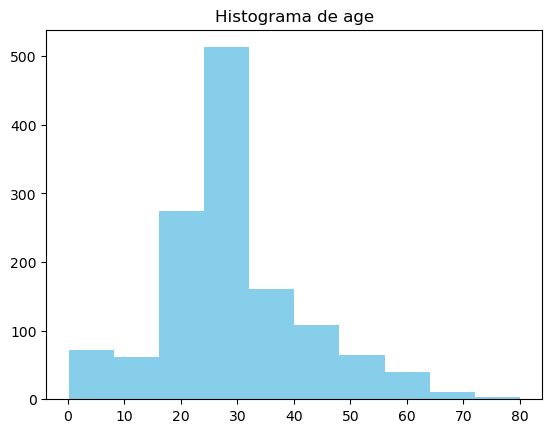

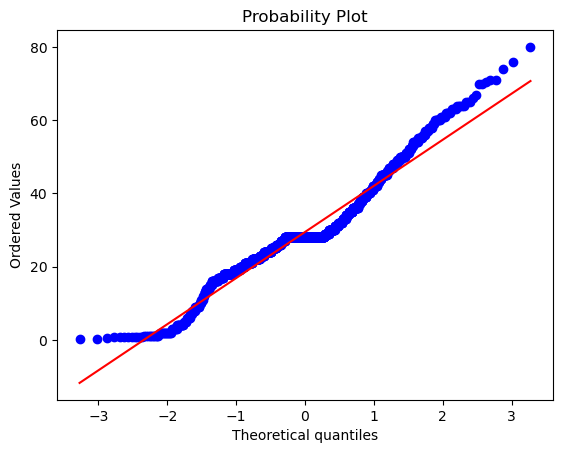

Prueba de Shapiro-Wilk
estadístico W=0.951, p-valor=0.000
Probablemente no es gaussiano


Análisis de la variable fare


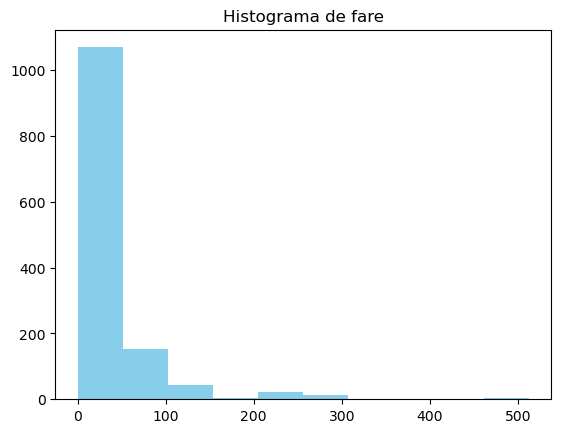

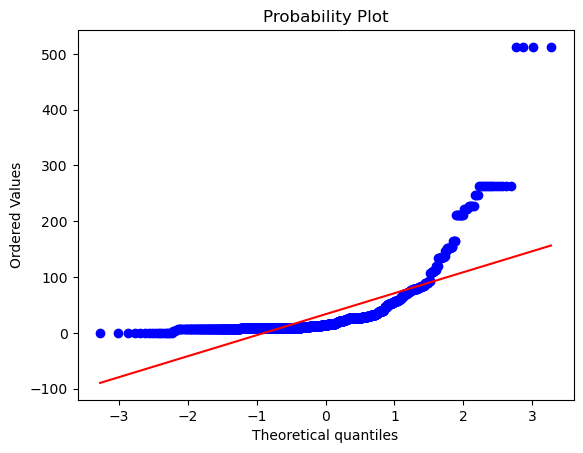

Prueba de Shapiro-Wilk
estadístico W=0.528, p-valor=0.000
Probablemente no es gaussiano


Análisis de la variable familysize


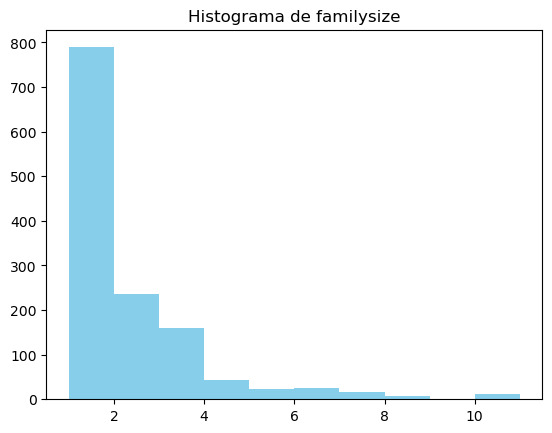

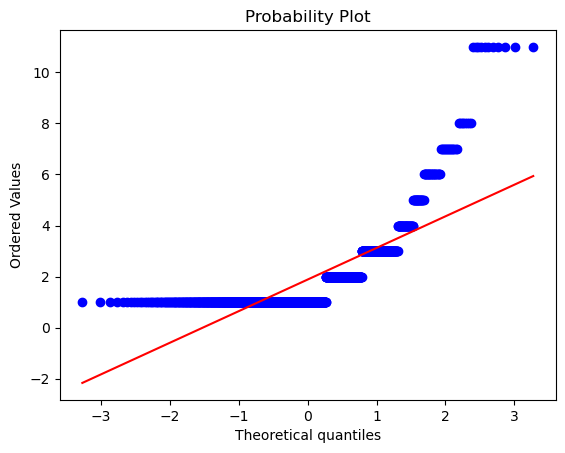

Prueba de Shapiro-Wilk
estadístico W=0.609, p-valor=0.000
Probablemente no es gaussiano




In [16]:
# Podríamos intentar realizar el análisis para todas las variables numéricas al mismo tiempo

numeric_vars = ['age', 'fare', 'familysize']

significance = 0.05 # para la prueba de Shapiro-Wilk

# Hacemos un loop por cada variable numérica

for var in numeric_vars:

    print(f'Análisis de la variable {var}')
    
    # Plot
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.set_title(f'Histograma de {var}')
    ax.hist(df_titanic_clean[var],
            color = 'skyblue')
    plt.show()

    # Q-Q plot
    
    st.probplot(df_titanic_clean[var],
               dist='norm',
               plot=plt)
    plt.show()

    # prueba de normalidad de Shapiro-Wilk
    standardized_var = st.zscore(df_titanic_clean[var])

    stat, p = st.shapiro(standardized_var)
    print('Prueba de Shapiro-Wilk')
    print('estadístico W=%.3f, p-valor=%.3f' % (stat,p))
    if p > significance:
        print('Probablemente es gaussiano')
    else:
        print('Probablemente no es gaussiano')
    print('\n')

Las variables `fare` y `familysize` presentan distribuciones notablemente asimétricas hacia la derecha, lo que puede afectar el rendimiento y la estabilidad de algunos modelos, especialmente aquellos que asumen linealidad, normalidad o varianza constante (como la regresión lineal o modelos bayesianos gaussianos). 

Para mitigar este sesgo, aplicamos una **transformación logarítmica** usando la función `log1p()`, que calcula el logaritmo natural de $1 + x$. Esta técnica tiene dos ventajas: primero, suaviza el efecto de valores extremos; segundo, permite transformar también valores iguales a cero sin generar errores.

Esta transformación no cambia el orden relativo de los datos, pero **mejora la forma de su distribución**, haciéndola más simétrica y más fácil de modelar de manera robusta.


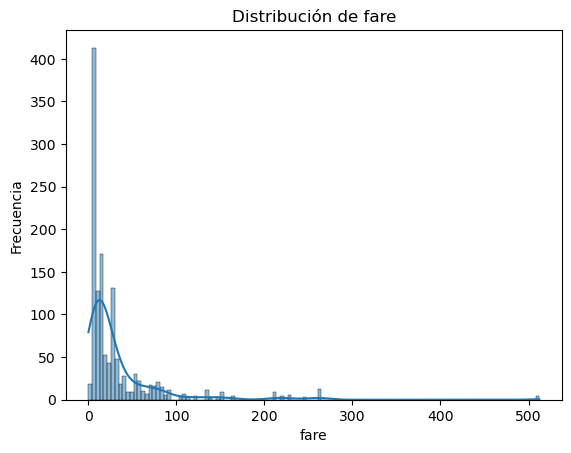

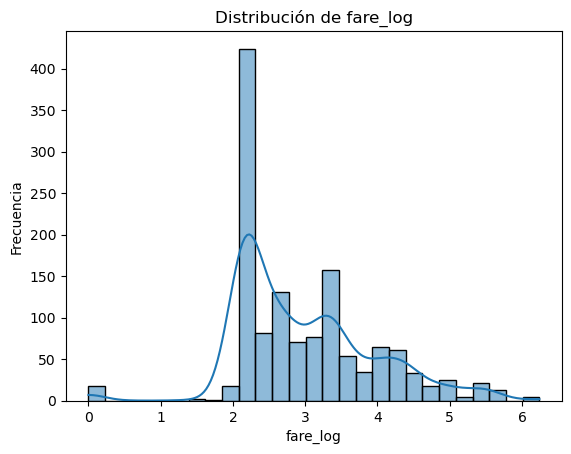

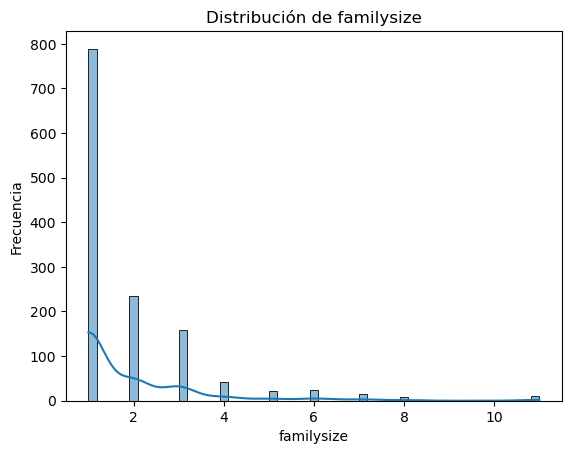

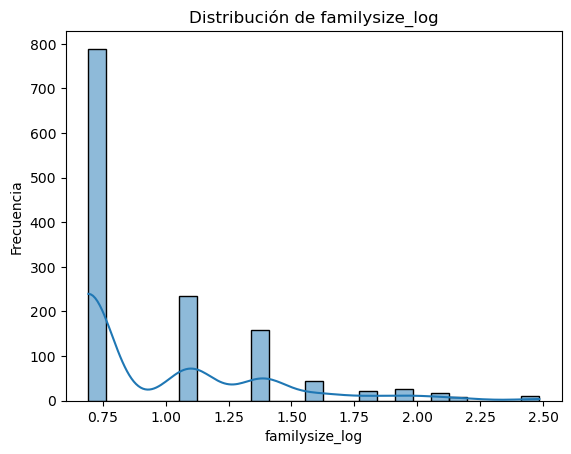

In [17]:
# Creamos nuevas columnas transformadas
df_titanic_clean['fare_log'] = np.log1p(df_titanic_clean['fare'])
df_titanic_clean['familysize_log'] = np.log1p(df_titanic_clean['familysize'])

# Visualizamos la diferencia en la distribución
for var in ['fare', 'fare_log', 'familysize', 'familysize_log']:
    sns.histplot(df_titanic_clean[var], kde=True)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()


Al aplicar la transformación logarítmica a las variables `fare` y `familysize`, observamos resultados distintos. En el caso de `fare`, la transformación con `log1p` **mejoró significativamente la simetría de la distribución**, reduciendo el sesgo y haciendo que los valores estén más concentrados en un rango útil para el modelado. Esto la convierte en una opción recomendable si se busca cumplir supuestos como normalidad o estabilidad de la varianza.

Por otro lado, la transformación aplicada a `familysize` **no generó una mejora sustancial**. Esto puede explicarse porque `familysize` es una variable discreta con pocos valores posibles y una distribución que ya está bastante concentrada en valores bajos. En estos casos, una transformación logarítmica no aporta mucho y podría incluso dificultar la interpretación.

Este contraste refuerza una idea clave: **no todas las transformaciones son automáticamente útiles para todas las variables**. Es importante analizar cada caso y tomar decisiones basadas en evidencia empírica, visual y estadística.

## Exploración visual del dataset en el contexto de la variable objetivo

Antes de construir modelos, es fundamental observar visualmente cómo se relacionan las variables del conjunto de datos con la variable objetivo (`survived`). Esto nos ayuda a **detectar patrones relevantes, identificar asociaciones no lineales, posibles outliers, y validar hipótesis previas** que pudimos haber planteado durante el proceso de limpieza y transformación.

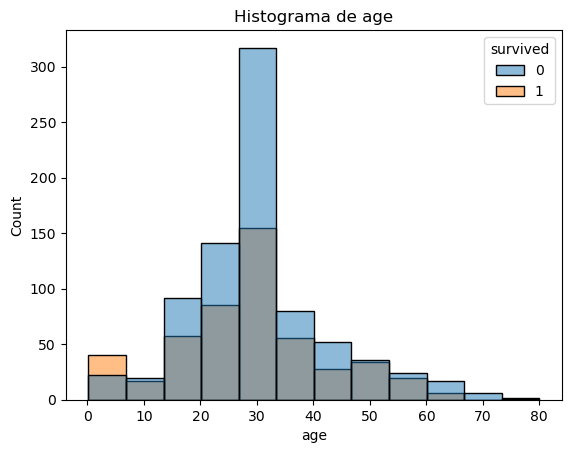

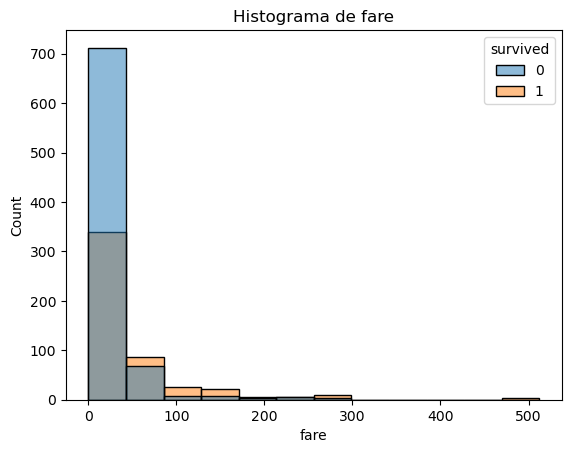

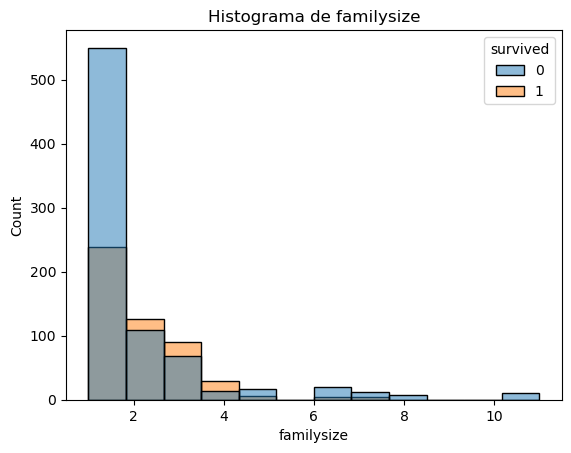

In [18]:
# Cómo hicimos anteriormente, podemos hacer histogramas de las variables numéricas para ver su distribución
# Esta vez lo hacemos con respecto a la variable objetivo
# Histograma de variables numéricas

numeric_vars = ['age', 'fare', 'familysize']

for var in numeric_vars:
    sns.histplot(data = df_titanic_clean,
                 x=var,
                 bins=12,
                 hue='survived')
    plt.title(f'Histograma de {var}')
    plt.show()

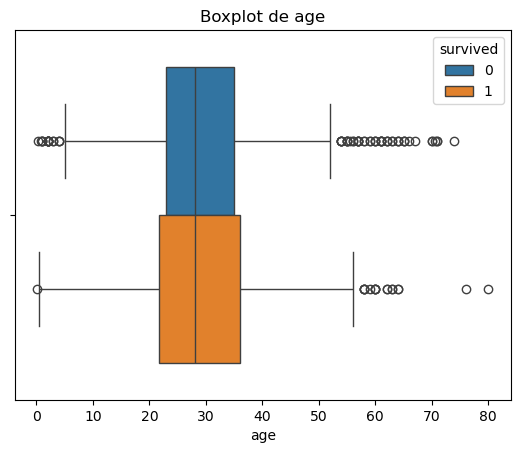

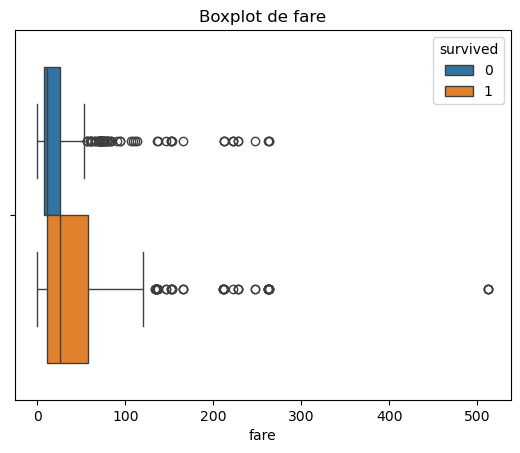

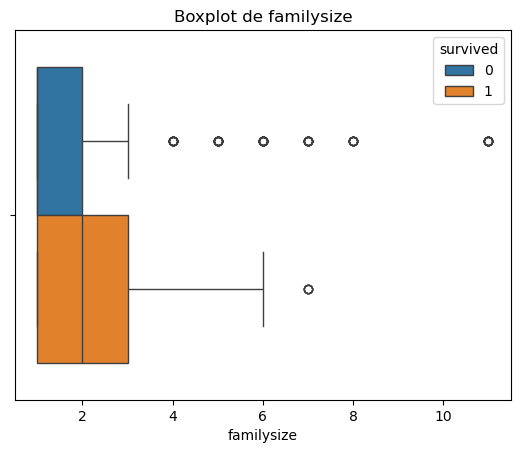

In [19]:
# Diagramas de caja y bigote
# Esto también nos ayuda para ver si hay valores atípicos

numeric_vars = ['age', 'fare', 'familysize']

for var in numeric_vars:

    sns.boxplot(data = df_titanic_clean,
                 x=var,
                 hue='survived')
    plt.title(f'Boxplot de {var}')
    plt.show()

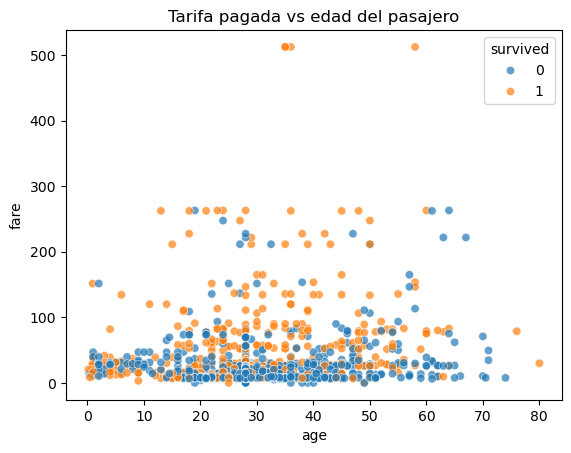

In [20]:
# Diagrama de dispersión

sns.scatterplot(data=df_titanic_clean,
                x='age',
                y='fare',
                hue='survived',
                alpha=0.7)
plt.title('Tarifa pagada vs edad del pasajero')
plt.show()

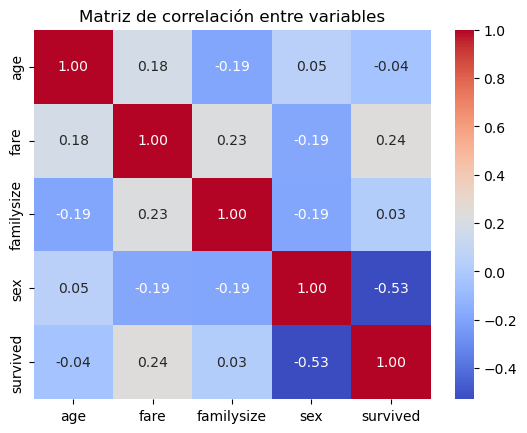

In [21]:
# Mapa de correlaciones
# Selección de variables numéricas relevantes
numeric_vars = ['age', 'fare', 'familysize', 'sex', 'survived']
corr_matrix = df_titanic_clean[numeric_vars].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación entre variables')
plt.show()

Además de las variables numéricas, las variables **categóricas** también pueden tener una relación importante con la variable objetivo `survived`. Para explorarlas, utilizamos **tablas de contingencia**, que muestran la frecuencia (y proporción) de ocurrencias de cada combinación de categorías.

Este análisis nos permite identificar, por ejemplo, si la proporción de supervivencia fue diferente según el **sexo**, la **clase del pasajero (`pclass`)** o incluso según los **títulos sociales (`title`)**. Estas tablas también pueden ser el punto de partida para aplicar pruebas de independencia, como el **chi-cuadrado**, si se desea avanzar hacia una inferencia más formal.

In [22]:
# Tabla de contingencia para Sex y Survived (frecuencias absolutas)
contingency_sex = pd.crosstab(df_titanic_clean['sex'], df_titanic_clean['survived'])
print("Tabla de contingencia: Sex vs Survived")
display(contingency_sex)

# Con proporciones (% sobre el total de cada fila)
contingency_sex_pct = pd.crosstab(df_titanic_clean['sex'], df_titanic_clean['survived'], normalize='index') * 100
print("Porcentaje de supervivencia por sexo:")
display(contingency_sex_pct)

# Repetimos para Pclass
print("Tabla de contingencia: Pclass vs Survived")
display(pd.crosstab(df_titanic_clean['pclass'], df_titanic_clean['survived']))

print("Porcentaje de supervivencia por clase:")
display(pd.crosstab(df_titanic_clean['pclass'], df_titanic_clean['survived'], normalize='index') * 100)


Tabla de contingencia: Sex vs Survived


survived,0,1
sex,,
0,127,339
1,681,161


Porcentaje de supervivencia por sexo:


survived,0,1
sex,,
0,27.253219,72.746781
1,80.878860,19.121140


Tabla de contingencia: Pclass vs Survived


survived,0,1
pclass,,
1,123,200
2,158,119
3,527,181


Porcentaje de supervivencia por clase:


survived,0,1
pclass,,
1,38.080495,61.919505
2,57.039711,42.960289
3,74.435028,25.564972


La exploración visual y tabular nos permitió identificar patrones claros en las variables tanto numéricas como categóricas en relación con la supervivencia. Observamos, por ejemplo, diferencias marcadas en las distribuciones de `fare` y `age` entre quienes sobrevivieron y quienes no, así como una mayor probabilidad de supervivencia entre mujeres y pasajeros de primera clase. Las tablas de contingencia confirmaron estos patrones y nos brindaron un resumen estructurado de cómo ciertas variables categóricas están asociadas con el resultado.

Estos hallazgos no solo enriquecen nuestra comprensión del contexto del problema, sino que también sirven como guía para la construcción de modelos predictivos: nos ayudan a seleccionar variables relevantes, validar supuestos y anticipar interacciones potenciales. Con esta base sólida, estamos listos para avanzar hacia la etapa de modelado.

## Primera aproximación al modelado: Regresión logística

Con los datos ya limpios, transformados y explorados, estamos listos para construir nuestro primer modelo de machine learning. En este caso, utilizaremos una **regresión logística**, un modelo estadístico clásico para problemas de clasificación binaria. Este modelo nos permitirá predecir la probabilidad de supervivencia de un pasajero (`survived`) en función de diversas variables explicativas como su edad, sexo, clase, tarifa pagada, tamaño del grupo familiar, entre otras.

La regresión logística es un excelente punto de partida porque es **interpretable, rápida y efectiva** para este tipo de problemas. Además, nos servirá como referencia base para evaluar modelos más complejos en etapas posteriores.

### Preparación de los datos para el modelo

Antes de entrenar el modelo, debemos definir qué variable queremos predecir (nuestra variable objetivo) y cuáles utilizaremos como predictores (variables explicativas). En este caso, la variable objetivo es `survived`, que indica si el pasajero sobrevivió o no.

También es importante dividir el dataset en dos subconjuntos:
- Uno para **entrenar** el modelo (train),
- Otro para **evaluar** su desempeño en datos no vistos (test).

Esta división es fundamental para evitar el sobreajuste y evaluar de forma honesta qué tan bien generaliza el modelo.


In [23]:
# Selección de variables predictoras
# Puedes ajustar esta lista si agregas o quitas columnas relevantes
features = [
    'pclass', 'sex', 'age', 'fare_log',
    'familysize', 'isalone',
    'embarked_Q', 'embarked_S',
    'title_Miss', 'title_Mrs', 'title_Mr', 'title_Rare'
]

X = df_titanic_clean[features] # matrix de características
y = df_titanic_clean['survived'] # vector de variable objetivo

# División en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verificamos las dimensiones
print("Dimensiones del conjunto de entrenamiento:", X_train.shape)
print("Dimensiones del conjunto de prueba:", X_test.shape)

Dimensiones del conjunto de entrenamiento: (1046, 12)
Dimensiones del conjunto de prueba: (262, 12)


### Entrenamiento y evaluación del modelo de regresión logística

Ahora que tenemos nuestros datos listos, entrenaremos un modelo de **regresión logística** usando las variables que seleccionamos previamente. Este modelo estima la probabilidad de que un pasajero haya sobrevivido en función de sus características. 

Una vez entrenado, evaluaremos su desempeño en el conjunto de prueba mediante métricas como la **exactitud (accuracy)**, la **matriz de confusión** y otras métricas complementarias. Esto nos permitirá tener una primera idea de qué tan bien generaliza el modelo a datos nuevos y sentar una base de comparación para futuros modelos.


In [25]:
# 1. Instanciamos el modelo, y sus hiperparámetros
logreg = LogisticRegression(max_iter=1000)
# 2. Ajustamos el modelo a nuestros datos (entrenamiento)
logreg.fit(X_train, y_train)
# 3. Realizamos predicciones sobre los datos de prueba
y_pred = logreg.predict(X_test)
# 4. Evaluamos nuestro modelo con métricas adecuadas
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print("\n Matriz de confusión:")
print(cm)

Accuracy: 0.8473

 Matriz de confusión:
[[144  18]
 [ 22  78]]


### Interpretación de resultados

Nuestro primer modelo de regresión logística logra predecir la supervivencia de los pasajeros con una precisión razonable, lo que nos indica que las variables que seleccionamos y transformamos efectivamente capturan información relevante del fenómeno. La matriz de confusión nos muestra cuántos casos fueron correctamente clasificados (verdaderos positivos y negativos).

Esta experiencia nos permite cerrar el ciclo completo de análisis: desde la limpieza y transformación de datos, hasta su exploración visual y aplicación práctica.

## Conclusión y transición hacia modelos supervisados

Con esta actividad finalizamos la primera unidad del curso, dedicada a la **estadística descriptiva, probabilidad, la exploración de datos y la preparación del dataset para el modelado**. Hemos aprendido a limpiar, transformar y analizar datos reales con una mirada crítica y estructurada, conectando conceptos de estadística con herramientas computacionales prácticas.

A partir de aquí, iniciaremos una nueva etapa enfocada en **modelos supervisados**, donde veremos cómo construir predictores a partir de datos etiquetados. Empezaremos por los modelos clásicos como la **regresión lineal**, la **regresión logística**, y luego avanzaremos hacia otros enfoques como  **árboles de decisión** y **ensambles**,**Naive Bayes**, **vecinos más cercanos**, etc.

El objetivo no es solo que puedas entrenar modelos, sino que aprendas a **elegirlos, interpretarlos y justificar tus decisiones con base en los datos**. Lo que aprendiste en esta unidad te dará una base sólida para todo lo que viene. ¡Vamos paso a paso, pero con profundidad y propósito!